# Vecchia 3D parameter estimation using maximum likelihood estimation

This example will cover:
 - Using the Vecchia approximation for drawing prior samples, inferring parameters and making predictions
 - Use maximum likelihood estimation to optimise kernel parameters

Code is heavily borrowed from github.com/mingdeyu/DGP

***GPVecchia uses `numba` so it is slow to run the first time.***

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time

from gpvecchia.vecchia import GPtideVecchia
from gptide import mle
from gpvecchia.cov import matern32

### Generate some 3D data

In [9]:
# Create some data coordinates
np.random.seed(0)

# Number of data points
totp = 10000

# spatial coords
xs = ys = zs = 400
X = np.column_stack((np.random.uniform(0, xs, totp),
                     np.random.uniform(0, ys, totp),
                     np.random.uniform(0, zs, totp))).astype(np.float64)
Xix = np.argsort(X[:,0])
X = X[Xix] # Data would generally come sorted along one dimension - Vecchia will do some re-ordering

print(X.shape)
print(xs*ys*zs)

(10000, 3)
64000000


In [10]:
# Example mean func
def my_mean(x, mean):
    return (np.ones(x.shape[0]) * mean)[:,None]

from numba import njit

@njit(cache=True)
def euclidean_vecch(X, Xpr):
    X_scaled = X - Xpr
    return np.sqrt(np.sum(X_scaled**2))

@njit(cache=True)
def matern32_covfunc_numba(x1, x2, cov_params):
    r = euclidean_vecch(x1, x2)
    return cov_params[0]**2 * matern32(r, 1.0)

In [ ]:
# These are our kernel input parameters
gp_noise = 0.0
gp_std = 0.1
xl = 80
yl = 40
zl = 5
xr = 0.6
yr = -0.65
tr = 0

# GPVecchia parameters
n_neighbours = 30 # number of neighbours to use
cov_func = matern32_covfunc_numba
cov_params = (gp_std, xl, yl, zl, xr, yr, tr)
mean_func = my_mean
mean_params = 0 #20.0
order_func = np.random.permutation # including a re-ordering function is important
order_params = len(X)
nn_kwargs = {'method':'sklearn'} # this SKLearn KD Tree method was fastest in testing so it is the default, but FAISS might be better on HPC

### Object initialisation

In [12]:
tstart = time.time()

gp_vec = GPtideVecchia(X, 
                       X,
                       gp_noise, 
                       cov_func, 
                       cov_params,
                       mean_func=mean_func, mean_params=mean_params,
                       order_func=order_func, order_params=order_params,
                       nnum=n_neighbours, nn_kwargs=nn_kwargs,
                       scale_coords=True, rotate_coords=True)

init_time = time.time() - tstart
print(f'Initialisation time: {init_time:.2f} seconds for {totp} points')
print(gp_vec)
print(gp_vec.nn_array.shape)
print(gp_vec.nn_array)

Initialisation time: 0.74 seconds for 10000 points
(10000, 31)
[[   0   -1   -1 ...   -1   -1   -1]
 [   1    0   -1 ...   -1   -1   -1]
 [   2    1    0 ...   -1   -1   -1]
 ...
 [9997 8637 8539 ...  428  258  232]
 [9998 9965 9590 ...  743  618    3]
 [9999 8468 8239 ...  631  546  450]]


In [13]:
gp_vec.rotate_params

array([ 0.6 , -0.65, -0.1 ])

### Draw from the prior

In [14]:
n_samp = 1

tstart = time.time()
smp_prior = gp_vec.sample_prior(samples=n_samp, add_noise=True)
sp_time = time.time() - tstart

print(f'Prior sampled in {sp_time:.2f} seconds')
print(smp_prior.shape)

Prior sampled in 4.52 seconds
(10000,)


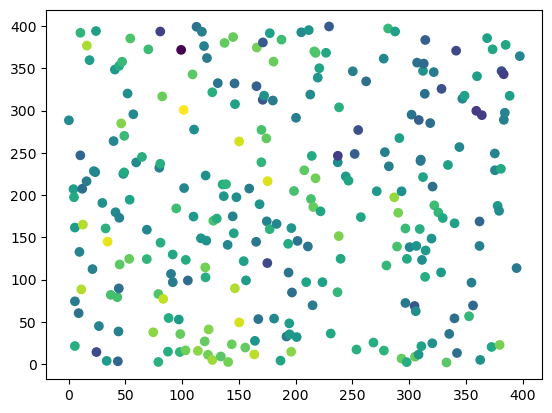

In [15]:
idx = X[:,-1] < 10
plt.scatter(X[:,0][idx], X[:,1][idx], c=smp_prior[idx], cmap='viridis')

### Evaluate the log-likelihood
Just using the true parameters here.

In [16]:
# Make one of the prior samples the input observations
y = smp_prior

sm_std = np.std(y - np.mean(y))
print(f'Small scale std dev.: {sm_std:.4}')
print(f'Mean: {np.mean(y):.4}')

tstart = time.time()
loglike = gp_vec.log_marg_likelihood(y)
ll_time = time.time() - tstart
print(f'Log likelihood computed in {ll_time:.3f} seconds')
print(loglike)

Small scale std dev.: 0.0946
Mean: -0.007065
Log likelihood computed in 7.809 seconds
[25389.20229189]


## MLE 

Try to infer the hyperparameters using maximum likelihood estimation. 

Will set the tolerance high because log-likelihood is a large number.

Didn't have much luck with gradient based methods, but there is an analytical form for the log-likelihood gradient which Ming has implemented (we could add).

In [ ]:
# Initial guess of the noise and covariance parameters (these can matter)
noise_ic = 0.0
covparams_ic = [0.4, 100., 50., 4., 0.2, -0.5, 0.]
meanparams_ic = [18.]

bnds_rc = [(0, 0), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None)]
bnds_rt = [(0, np.pi/2), (-np.pi/2, 0), (0, 0)]
bnds_mn = [(None, None)]
bnds = bnds_rc + bnds_rt #+ bnds_mn

soln = mle(
    X,
    y,
    cov_func,
    covparams_ic,
    noise_ic,
    # meanfunc=mean_func,
    # meanparams_ic=meanparams_ic,
    method='Nelder-Mead',
    GPclass=GPtideVecchia,
    gp_kwargs={'order_func':order_func, 'order_params':order_params, 'nnum':30,\
                'nn_kwargs':nn_kwargs, 'scale_coords':True, 'rotate_coords':True},
    bounds=bnds,
    verbose=True)


print('Noise (true): {:3.4f}, |Noise| (mle): {:3.4f}'.format(gp_noise, soln['x'][0]))
print('η (true): {:3.3f}, η (mle): {:3.3f}'.format(sm_std, soln['x'][1]))
print('ℓx (true): {:3.2f}, ℓx (mle): {:3.2f}'.format(cov_params[1], soln['x'][2]))
print('ℓy (true): {:3.2f}, ℓy (mle): {:3.2f}'.format(cov_params[2], soln['x'][3]))
print('ℓt (true): {:3.2f}, ℓt (mle): {:3.2f}'.format(cov_params[3], soln['x'][4]))
print('mean (true): {:3.2f}, mean (mle): {:3.2f}'.format(np.mean(y), soln['x'][-1]))

print('Rotation (true): {:3.2f}, Rotation (mle): {:3.2f}'.format(cov_params[4], soln['x'][5]))
print('Translation (true): {:3.2f}, Translation (mle): {:3.2f}'.format(cov_params[5], soln['x'][6]))
print('Rotation (true): {:3.2f}, Rotation (mle): {:3.2f}'.format(cov_params[6], soln['x'][7]))


[  0.    0.4 100.   50.    4.    0.2  -0.5   0. ]
[-14911.43547729]
[  0.    0.4 100.   50.    4.    0.2  -0.5   0. ]
[-14913.42063909]
[  0.     0.42 100.    50.     4.     0.2   -0.5    0.  ]
[-14629.87192941]
[  0.    0.4 105.   50.    4.    0.2  -0.5   0. ]
[-14954.29320679]
[  0.    0.4 100.   52.5   4.    0.2  -0.5   0. ]
[-14978.73336514]
[  0.    0.4 100.   50.    4.2   0.2  -0.5   0. ]
[-15009.31069303]
[  0.     0.4  100.    50.     4.     0.21  -0.5    0.  ]
[-14913.84471932]
[  0.      0.4   100.     50.      4.      0.2    -0.525   0.   ]
[-14901.57675038]
[ 0.0e+00  4.0e-01  1.0e+02  5.0e+01  4.0e+00  2.0e-01 -5.0e-01  2.5e-04]
[-14917.38123089]
[ 0.0000e+00  3.8000e-01  1.0125e+02  5.0625e+01  4.0500e+00  2.0250e-01
 -5.0625e-01  6.2500e-05]
[-15229.35534736]
[ 0.00000e+00  3.60000e-01  1.01875e+02  5.09375e+01  4.07500e+00
  2.03750e-01 -5.09375e-01  9.37500e-05]
[-15487.83076658]
[ 0.0000000e+00  3.9000000e-01  1.0171875e+02  5.0859375e+01
  4.0687500e+00  2.0343750e-0

KeyboardInterrupt: 

### Evaluating the likelihood gradient

***Not implemented yet***

## Conditioning on data

Mean and variance predictions 

In [ ]:
x_pred = np.linspace(0, xs, 50)
y_pred = np.linspace(0, ys, 50)
z_pred = np.linspace(0, zs, 20)

# Prediction points dont need to be randomly ordered
xx_grid, yy_grid, zz_grid = np.meshgrid(x_pred, y_pred, z_pred, indexing='ij')
X_pred = np.column_stack((xx_grid.ravel(), yy_grid.ravel(), zz_grid.ravel())).astype(np.float64)
print(X_pred.shape)

(50000, 3)


In [ ]:
gp_vec = GPtideVecchia(X, 
                       X_pred,
                       gp_noise, 
                       cov_func, 
                       cov_params,
                       mean_func=mean_func, mean_params=mean_params,
                       order_func=order_func, order_params=order_params,
                       nnum=n_neighbours, nn_kwargs=nn_kwargs)

tstart = time.time()
y_mean, y_uq = gp_vec(y)
cnd_time = time.time() - tstart

print(f'Conditioning completed in {cnd_time:.2f} seconds')
print(y_mean.shape)
print('Pred variance:', np.var(y_mean - np.mean(y_mean)))
print(y_uq.shape)

Conditioning completed in 6.16 seconds
(50000,)
Pred variance: 0.1935583606809763
(50000,)


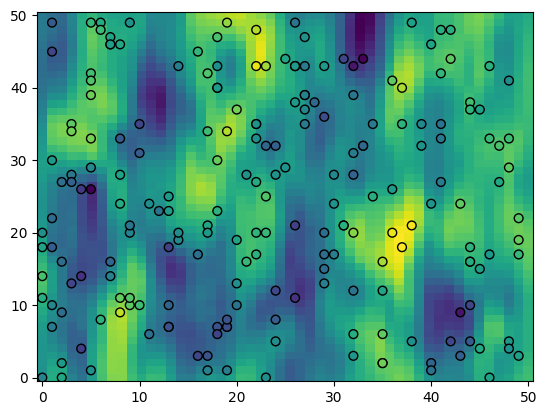

In [ ]:
plt.pcolormesh(xx_grid[:,:,0], yy_grid[:,:,0], y_mean.reshape(xx_grid.shape)[:,:,0], cmap='viridis')

idx = X[:,-1] == 0
plt.scatter(X[:,0][idx], X[:,1][idx], c=y[idx], cmap='viridis', ec='k', s=40)

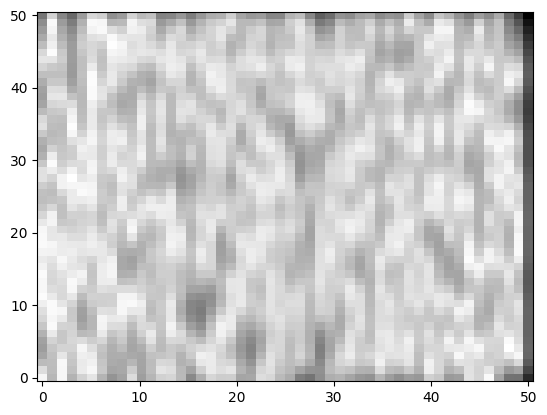

In [ ]:
plt.pcolormesh(xx_grid[:,:,0], yy_grid[:,:,0], y_uq.reshape(xx_grid.shape)[:,:,0], cmap='gray_r')

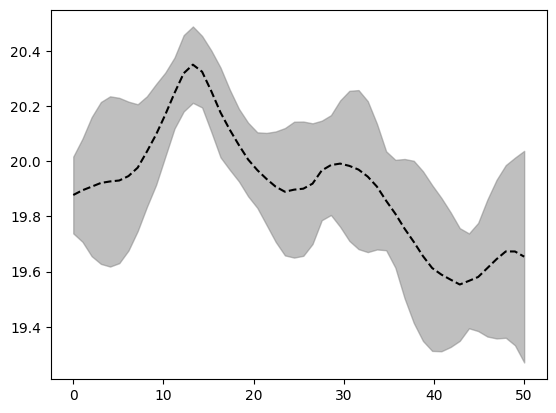

In [ ]:
plt.plot(xx_grid[:,0,0], y_mean.reshape(xx_grid.shape)[0,:,0], 'k--')
plt.fill_between(xx_grid[:,0,0],
                 y_mean.reshape(xx_grid.shape)[0,:,0] - 2*y_uq.reshape(xx_grid.shape)[0,:,0],\
                 y_mean.reshape(xx_grid.shape)[0,:,0] + 2*y_uq.reshape(xx_grid.shape)[0,:,0],\
                 color='gray', alpha=0.5)